In [1]:
import yggdrasilDecisionForests.yggdrasil_decision_forests as ydf


treeple1 environment

In [2]:
! pip install ydf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 41.5 MB/s eta 0:00:00a 0:00:01


In [1]:
import ydf

In [4]:
! pip install pandas

  Using cached pandas-2.2.3-cp310-cp310-macosx_11_0_arm64.whl.metadata (89 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.3-cp310-cp310-macosx_11_0_arm64.whl (11.3 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)


In [2]:
import treeple
from treeple.datasets import make_trunk_classification
import pandas as pd
import time
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [3]:
def prepare_dataframe(X, y):
    df = pd.DataFrame(X)
    df.columns = [str(i) for i in df.columns]  # Convert column names to strings
    df["target"] = y.astype(int)  # Append target column

    return df

def train_ydf(X_train, y_train, X_test, y_test, params_ydf, n_dim=500):
    df_train = prepare_dataframe(X_train, y_train)
    df_test = prepare_dataframe(X_test, y_test)

    learner = ydf.RandomForestLearner(**params_ydf)
    start_time = time.time()
    ydf_model = learner.train(df_train)
    time_ydf = time.time() - start_time
    y_pred = ydf_model.predict(df_test)
    y_pred_class = (y_pred >= 0.5).astype(int) 

    acc_ydf = accuracy_score(y_test, y_pred_class)

    print(f"YDF | n_dim: {n_dim} | n_tree: {params_ydf['num_trees']} | Accuracy: {acc_ydf:.4f} | Train Time: {time_ydf:.4f} sec")
    return acc_ydf, time_ydf, y_pred_class

In [107]:
MAX_DEPTH = 10
N_ESTIMATORS = 300
RANDOM_SEED = 42
N_JOBS=-1
BOOTSTRAP = True
MAX_FEATURE = 100
FEATURE_COMBINATIONS = 1.0

params_ydf = dict()
params_ydf["label"] = "target"
params_ydf["max_depth"] = MAX_DEPTH
params_ydf["num_trees"] = N_ESTIMATORS
params_ydf["random_seed"] = RANDOM_SEED
params_ydf["honest"] = False
params_ydf["bootstrap_size_ratio"] = 1.0
params_ydf["bootstrap_training_dataset"] = BOOTSTRAP
params_ydf["categorical_algorithm"] = "ONE_HOT"
params_ydf["compute_oob_performances"] = False  #oob_score
params_ydf["compute_oob_variable_importances"] = False  ## oob_score
params_ydf["in_split_min_examples_check"] = True
params_ydf["min_examples"] = 1    #min_samples_leaf
params_ydf["keep_non_leaf_label_distribution"] = True   # not sure
params_ydf["max_num_nodes"] = None
params_ydf["growing_strategy"] = "BEST_FIRST_GLOBAL"
# params_ydf["num_candidate_attributes"] = -1  #0 equivalent to sqrt max_features in treeple
params_ydf["num_candidate_attributes_ratio"] = 1.0
params_ydf["sorting_strategy"] = "IN_NODE" ###
# sparse oblique params
params_ydf["split_axis"] = "SPARSE_OBLIQUE"
params_ydf["sparse_oblique_weights"] = "BINARY"
params_ydf["sparse_oblique_projection_density_factor"] = FEATURE_COMBINATIONS
params_ydf["sparse_oblique_normalization"] = "NONE" #"MIN_MAX"
params_ydf["sparse_oblique_max_num_projections"] = MAX_FEATURE # modify this, find in sourse code in treeple
params_ydf["sparse_oblique_num_projections_exponent"] = 1.0   #2.0
params_ydf["sampling_with_replacement"] = False

In [108]:
n_samples=2000
num_dim=10
X, y = make_trunk_classification(n_samples=n_samples, n_dim=num_dim, n_informative=600, seed=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

df_train = prepare_dataframe(X_train, y_train)
df_test = prepare_dataframe(X_test, y_test)

c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


In [109]:
learner = ydf.RandomForestLearner(**params_ydf)
start_time = time.time()
ydf_model = learner.train(df_train)
time_ydf = time.time() - start_time
pred_ydf = ydf_model.predict(df_test)
pred_ydf = (pred_ydf >= 0.5).astype(int) 

acc_ydf = accuracy_score(y_test, pred_ydf)
acc_ydf

Train model on 1600 examples
Model trained in 0:00:00.116596


0.745

In [38]:
learner.hyperparameter_templates()

{'better_defaultv1': HyperparameterTemplate(name='better_default', version=1, parameters={'winner_take_all': True}, description='A configuration that is generally better than the default parameters without being more expensive.'),
 'benchmark_rank1v1': HyperparameterTemplate(name='benchmark_rank1', version=1, parameters={'winner_take_all': True, 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}, description='Top ranking hyper-parameters on our benchmark slightly modified to run in reasonable time.')}

In [39]:
ydf_model.describe()

In [9]:
ydf_model.save("saved_model/")

In [40]:
ydf_model.data_spec()

columns {
  type: CATEGORICAL
  name: "target"
  categorical {
    number_of_unique_values: 3
    items {
      key: "<OOD>"
      value {
        index: 0
        count: 0
      }
    }
    items {
      key: "1"
      value {
        index: 2
        count: 800
      }
    }
    items {
      key: "0"
      value {
        index: 1
        count: 800
      }
    }
  }
  count_nas: 0
  dtype: DTYPE_INT32
}
columns {
  type: NUMERICAL
  name: "0"
  numerical {
    mean: 0.50206137866509382
    min_value: -3.38852024
    max_value: 3.77264
    standard_deviation: 1.0926331375419041
  }
  count_nas: 0
  dtype: DTYPE_FLOAT64
}
columns {
  type: NUMERICAL
  name: "1"
  numerical {
    mean: 0.32230514054055676
    min_value: -3.55543637
    max_value: 4.28789711
    standard_deviation: 1.051411575474217
  }
  count_nas: 0
  dtype: DTYPE_FLOAT64
}
columns {
  type: NUMERICAL
  name: "2"
  numerical {
    mean: 0.26846194128011119
    min_value: -3.21311045
    max_value: 3.50855422
    stan

In [41]:
ydf_tree = ydf_model.get_tree(1)
ydf_tree

Tree(root=NonLeaf(value=ProbabilityValue(num_examples=1600.0, probability=[0.5, 0.5]), condition=NumericalSparseObliqueCondition(missing=False, score=0.053251296281814575, attributes=[2, 5, 6], weights=[-0.052857689559459686, -0.12740656733512878, -0.0796140506863594], threshold=-0.044604748487472534), pos_child=NonLeaf(value=ProbabilityValue(num_examples=742.0, probability=[0.6738544474393531, 0.3261455525606469]), condition=NumericalSparseObliqueCondition(missing=False, score=0.040539998561143875, attributes=[1, 3], weights=[-0.0028991461731493473, -0.08910401165485382], threshold=-0.008685402572154999), pos_child=NonLeaf(value=ProbabilityValue(num_examples=342.0, probability=[0.8157894736842105, 0.18421052631578946]), condition=NumericalSparseObliqueCondition(missing=False, score=0.04142618179321289, attributes=[4], weights=[1.0], threshold=0.04757502302527428), pos_child=NonLeaf(value=ProbabilityValue(num_examples=183.0, probability=[0.7158469945355191, 0.28415300546448086]), condi

In [43]:
ydf_root = ydf_tree.root
ydf_root

NonLeaf(value=ProbabilityValue(num_examples=1600.0, probability=[0.5, 0.5]), condition=NumericalSparseObliqueCondition(missing=False, score=0.053251296281814575, attributes=[2, 5, 6], weights=[-0.052857689559459686, -0.12740656733512878, -0.0796140506863594], threshold=-0.044604748487472534), pos_child=NonLeaf(value=ProbabilityValue(num_examples=742.0, probability=[0.6738544474393531, 0.3261455525606469]), condition=NumericalSparseObliqueCondition(missing=False, score=0.040539998561143875, attributes=[1, 3], weights=[-0.0028991461731493473, -0.08910401165485382], threshold=-0.008685402572154999), pos_child=NonLeaf(value=ProbabilityValue(num_examples=342.0, probability=[0.8157894736842105, 0.18421052631578946]), condition=NumericalSparseObliqueCondition(missing=False, score=0.04142618179321289, attributes=[4], weights=[1.0], threshold=0.04757502302527428), pos_child=NonLeaf(value=ProbabilityValue(num_examples=183.0, probability=[0.7158469945355191, 0.28415300546448086]), condition=Numer

In [44]:
ydf_root.neg_child

NonLeaf(value=ProbabilityValue(num_examples=858.0, probability=[0.34965034965034963, 0.6503496503496503]), condition=NumericalSparseObliqueCondition(missing=False, score=0.027874784544110298, attributes=[2], weights=[1.0], threshold=0.8453803062438965), pos_child=NonLeaf(value=ProbabilityValue(num_examples=354.0, probability=[0.2175141242937853, 0.7824858757062146]), condition=NumericalSparseObliqueCondition(missing=False, score=0.02652428299188614, attributes=[3], weights=[1.0], threshold=0.36735761165618896), pos_child=NonLeaf(value=ProbabilityValue(num_examples=187.0, probability=[0.12834224598930483, 0.8716577540106952]), condition=NumericalSparseObliqueCondition(missing=False, score=0.034788746386766434, attributes=[8], weights=[1.0], threshold=0.052107613533735275), pos_child=Leaf(value=ProbabilityValue(num_examples=110.0, probability=[0.05454545454545454, 0.9454545454545454])), neg_child=NonLeaf(value=ProbabilityValue(num_examples=77.0, probability=[0.23376623376623376, 0.766233

In [45]:
root_str = str(ydf_root)

In [125]:
import re
import numpy as np
from scipy.sparse import lil_matrix

def extract_projections(tree_str):
    
    attr_blocks = re.findall(r'attributes=\[([0-9,\s]+)\]\s*,\s*weights=\[([0-9eE+.\-,\s]+)\]', tree_str)
    print(len(attr_blocks))
    projection_rows = []
    max_feature_index = -1

    for attr_str, weight_str in attr_blocks:
        print(attr_str)
        attrs = [int(i.strip()) for i in attr_str.split(',') if i.strip()]
        weights = [float(w.strip()) for w in weight_str.split(',') if w.strip()]
        
        if len(attrs) != len(weights):
            raise ValueError(f"Mismatched attributes and weights: {attrs}, {weights}")
        
        # Track the maximum feature index
        if attrs:
            max_feature_index = max(max_feature_index, max(attrs))
        
        projection_rows.append((attrs, weights))

    # Projection dimension = max feature index + 1
    proj_dim = max_feature_index + 1

    # Initialize sparse projection matrix
    projection_matrix = lil_matrix((len(projection_rows), proj_dim))
    for i, (attrs, weights) in enumerate(projection_rows):
        for j, attr in enumerate(attrs):
            projection_matrix[i, attr] = weights[j]

    return projection_matrix, proj_dim


In [204]:
import re
import numpy as np
from scipy.sparse import lil_matrix

def extract_projections(tree_str):
    """
    Parses a string representation of a YDF decision tree to extract the projection matrix,
    compute its dimension (number of input features), and count non-zero weights.

    Args:
        tree_str (str): Stringified tree structure starting from the root node.

    Returns:
        projection_matrix (scipy.sparse.lil_matrix): Sparse matrix of projections.
        proj_dim (int): Dimensionality of each projection (i.e., number of input features).
        num_nonzeros (int): Total number of non-zero weights in the matrix.
    """
    # Find all attribute-weight pairs
    attr_blocks = re.findall(
        r'attributes=\[([0-9,\s]+)\]\s*,\s*weights=\[([0-9eE+.\-,\s]+)\]',
        tree_str
    )
    # print("num of dense vectors: ", len(attr_blocks))

    projection_rows = []
    max_feature_index = -1
    total_nonzeros = 0

    for attr_str, weight_str in attr_blocks:
        attrs = [int(i.strip()) for i in attr_str.split(',') if i.strip()]
        weights = [float(w.strip()) for w in weight_str.split(',') if w.strip()]
        
        if len(attrs) != len(weights):
            raise ValueError(f"Mismatched attributes and weights: {attrs}, {weights}")
        
        total_nonzeros += len(weights)  # Count all weights (assumed non-zero)
        if attrs:
            max_feature_index = max(max_feature_index, max(attrs))
        
        projection_rows.append((attrs, weights))

    proj_dim = max_feature_index + 1 if max_feature_index >= 0 else 0
    projection_matrix = lil_matrix((len(projection_rows), proj_dim))

    for i, (attrs, weights) in enumerate(projection_rows):
        for j, attr in enumerate(attrs):
            projection_matrix[i, attr] = weights[j]

    return projection_matrix, proj_dim, total_nonzeros


In [182]:
projection_matrix, proj_dim, total_nonzeros = extract_projections(root_str)
total_nonzeros

44

In [183]:
projection_matrix2, proj_dim2, total_nonzeros2 = extract_projections(str(ydf_root.neg_child))
total_nonzeros2

26

In [184]:
projection_matrix3, proj_dim3, total_nonzeros3 = extract_projections(str(ydf_root.pos_child))
total_nonzeros3

15

In [49]:
proj_dim
projection_matrix.shape

(30, 11)

In [42]:
len(ydf_model.get_all_trees())

300

## Do a pipline

In [110]:
params_ydf

{'label': 'target',
 'max_depth': 10,
 'num_trees': 300,
 'random_seed': 42,
 'honest': False,
 'bootstrap_size_ratio': 1.0,
 'bootstrap_training_dataset': True,
 'categorical_algorithm': 'ONE_HOT',
 'compute_oob_performances': False,
 'compute_oob_variable_importances': False,
 'in_split_min_examples_check': True,
 'min_examples': 1,
 'keep_non_leaf_label_distribution': True,
 'max_num_nodes': None,
 'growing_strategy': 'BEST_FIRST_GLOBAL',
 'num_candidate_attributes_ratio': 1.0,
 'sorting_strategy': 'IN_NODE',
 'split_axis': 'SPARSE_OBLIQUE',
 'sparse_oblique_weights': 'BINARY',
 'sparse_oblique_projection_density_factor': 1.0,
 'sparse_oblique_normalization': 'NONE',
 'sparse_oblique_max_num_projections': 100,
 'sparse_oblique_num_projections_exponent': 1.0,
 'sampling_with_replacement': False}

In [226]:
params_ydf['bootstrap_training_dataset'] = False

In [225]:
def get_ydf_model(params_ydf, n_sample=2000, n_estimator=100, n_dim=50, 
                    max_feature=100, feature_combination=3.0, exponent=1.0):
    X, y = make_trunk_classification(n_samples=n_sample, n_dim=n_dim, n_informative=600, seed=0)
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    df_train = prepare_dataframe(X_train, y_train)

    params_ydf1 = params_ydf.copy()
    params_ydf1["num_trees"] = n_estimator
    params_ydf1["sparse_oblique_max_num_projections"] = max_feature
    params_ydf1["sparse_oblique_projection_density_factor"] = feature_combination
    params_ydf1["sparse_oblique_num_projections_exponent"] = exponent


    learner = ydf.RandomForestLearner(**params_ydf1)
    start_time = time.time()
    ydf_model = learner.train(df_train)
    time_taken = time.time() - start_time
    return ydf_model, time_taken

In [194]:
def extract_projections_pipline(params_ydf, n_sample=2000, n_estimator=100, n_dim=50, 
                                max_feature=100, feature_combination=3.0, exponent=1.0,
                                tree_id=0):
    
    X, y = make_trunk_classification(n_samples=n_sample, n_dim=n_dim, n_informative=600, seed=0)
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    df_train = prepare_dataframe(X_train, y_train)

    params_ydf1 = params_ydf.copy()
    params_ydf1["num_trees"] = n_estimator
    params_ydf1["sparse_oblique_max_num_projections"] = max_feature
    params_ydf1["sparse_oblique_projection_density_factor"] = feature_combination
    params_ydf1["sparse_oblique_num_projections_exponent"] = exponent


    learner = ydf.RandomForestLearner(**params_ydf1)
    start_time = time.time()
    ydf_model = learner.train(df_train)
    time_taken = time.time() - start_time

    root_str = str(ydf_model.get_tree(tree_id).root)
    print("*",root_str)
    projection_matrix, proj_dim, n_nonzeros = extract_projections(root_str)

    print("nonzeros number:", n_nonzeros)
    print("projection matrix shape:", projection_matrix.shape)

    return projection_matrix, proj_dim, n_nonzeros, time_taken, ydf_model

get average n_nonzeros

In [215]:
def extract_avg_projection(params_ydf, n_sample=2000, n_estimator=100, n_dim=50, 
                                max_feature=100, feature_combination=3.0, exponent=1.0):
    X, y = make_trunk_classification(n_samples=n_sample, n_dim=n_dim, n_informative=600, seed=0)
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    df_train = prepare_dataframe(X_train, y_train)

    params_ydf1 = params_ydf.copy()
    params_ydf1["num_trees"] = n_estimator
    params_ydf1["sparse_oblique_max_num_projections"] = max_feature
    params_ydf1["sparse_oblique_projection_density_factor"] = feature_combination
    params_ydf1["sparse_oblique_num_projections_exponent"] = exponent


    learner = ydf.RandomForestLearner(**params_ydf1)
    start_time = time.time()
    ydf_model = learner.train(df_train)
    time_taken = time.time() - start_time

    non_zeros = np.zeros((n_estimator,))
    proj_dim1 = np.zeros((n_estimator,))
    proj_dim2 = np.zeros((n_estimator,))
    for tree_id in range(n_estimator):
        root_str = str(ydf_model.get_tree(tree_id).root)
        #print("*",root_str)
        projection_matrix, proj_dim, n_nonzeros = extract_projections(root_str)

        non_zeros[tree_id] = n_nonzeros
        proj_dim1[tree_id] = projection_matrix.shape[0]
        proj_dim2[tree_id] = projection_matrix.shape[1]

    avg_non_zeros = np.mean(non_zeros)
    avg_proj_dim1 = np.mean(proj_dim1)
    avg_proj_dim2 = np.mean(proj_dim2)
    print("Average projection matrix shape:", avg_proj_dim1, avg_proj_dim2)
    print("Average nonzeros number:", avg_non_zeros)

    return avg_proj_dim1, avg_proj_dim2, avg_non_zeros, time_taken, ydf_model

In [228]:
_,_,avg_non_zeros,_,_ = extract_avg_projection(params_ydf, n_sample=2000, n_estimator=100, n_dim=100,
                                max_feature=10, feature_combination=3.0, exponent=10.0)

Train model on 1600 examples
Model trained in 0:00:00.012003
Average projection matrix shape: 30.0 100.34
Average nonzeros number: 90.14


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


In [240]:
_,_,avg_non_zeros,_,_ = extract_avg_projection(params_ydf, n_sample=2000, n_estimator=100, n_dim=2,
                                max_feature=20, feature_combination=0.1, exponent=1.0)

Train model on 1600 examples
Model trained in 0:00:00.014001
Average projection matrix shape: 30.0 3.0
Average nonzeros number: 30.09


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 2. Setting n_informative to n_dim.
  warnings.warn(


In [241]:
projection_matrix, proj_dim, n_nonzeros, time_taken, ydf_model = extract_projections_pipline(params_ydf,
                                                n_sample=2000, 
                                                n_estimator=100, 
                                                n_dim=50, 
                                                max_feature=100, 
                                                feature_combination=3.0,
                                                tree_id=10)
#projection_matrix.shape

Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 50. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.249013
* NonLeaf(value=ProbabilityValue(num_examples=1600.0, probability=[0.5, 0.5]), condition=NumericalSparseObliqueCondition(missing=False, score=0.04539964348077774, attributes=[1, 22, 24, 36], weights=[1.0, 1.0, 1.0, -1.0], threshold=0.20489168167114258), pos_child=NonLeaf(value=ProbabilityValue(num_examples=945.0, probability=[0.37566137566137564, 0.6243386243386243]), condition=NumericalSparseObliqueCondition(missing=False, score=0.05753398314118385, attributes=[2, 4, 19, 25], weights=[1.0, 1.0, 1.0, 1.0], threshold=1.6286503076553345), pos_child=NonLeaf(value=ProbabilityValue(num_examples=384.0, probability=[0.18229166666666666, 0.8177083333333334]), condition=NumericalSparseObliqueCondition(missing=False, score=0.027746761217713356, attributes=[1, 25, 37, 40], weights=[-1.0, -1.0, -1.0, -1.0], threshold=-0.22032347321510315), pos_child=Leaf(value=ProbabilityValue(num_examples=61.0, probability=[0.4098360655737705, 0.5901639344262295])), neg_child=NonLe

In [246]:
ydf_model.get_tree(10).root.pos_child.condition

NumericalSparseObliqueCondition(missing=False, score=0.05753398314118385, attributes=[2, 4, 19, 25], weights=[1.0, 1.0, 1.0, 1.0], threshold=1.6286503076553345)

In [253]:
avg_nonzero_element_num = np.zeros((5,))
for i in range(1, 5):
    print("==========")
    print("feature combination = ", i)
    _,_,avg_non_zeros,_,_ = extract_avg_projection(params_ydf, n_sample=2000, n_estimator=100, n_dim=100,
                                max_feature=20, feature_combination=float(i), exponent=2.0)
    avg_nonzero_element_num[i] = avg_non_zeros/30
    #print("nonzeros number:", n_nonzeros)
    #print("projection matrix shape:", projection_matrix.shape)

feature combination =  1
Train model on 1600 examples
Model trained in 0:00:00.099124
Average projection matrix shape: 30.0 96.65
Average nonzeros number: 42.12
feature combination =  2
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(
c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.133806
Average projection matrix shape: 30.0 99.22
Average nonzeros number: 65.1
feature combination =  3
Train model on 1600 examples
Model trained in 0:00:00.096644
Average projection matrix shape: 30.0 99.98
Average nonzeros number: 91.22
feature combination =  4
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(
c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.096125
Average projection matrix shape: 30.0 100.44
Average nonzeros number: 120.87


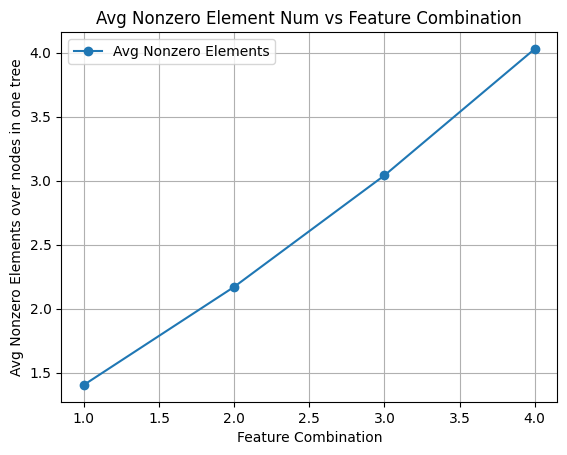

In [255]:
import matplotlib.pyplot as plt

feature_combinations = range(1, 5)  # Corresponding to the feature combination values used
plt.plot(feature_combinations, avg_nonzero_element_num[1:], marker='o', label='Avg Nonzero Elements')
plt.xlabel('Feature Combination')
plt.ylabel('Avg Nonzero Elements over nodes in one tree')
plt.title('Avg Nonzero Element Num vs Feature Combination')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
projection_matrix, proj_dim, _, _, _ = extract_projections_pipline(params_ydf,
                                                n_sample=2000, 
                                                n_estimator=100, 
                                                n_dim=1000, 
                                                max_feature=100, 
                                                feature_combination=3.0)
projection_matrix.shape

Train model on 1600 examples
Model trained in 0:00:00.827913
* NonLeaf(value=ProbabilityValue(num_examples=1600.0, probability=[0.5, 0.5]), condition=NumericalSparseObliqueCondition(missing=False, score=0.010048951022326946, attributes=[7, 56, 721, 783], weights=[1.0, 1.0, 1.0, -1.0], threshold=-0.30478930473327637), pos_child=NonLeaf(value=ProbabilityValue(num_examples=1015.0, probability=[0.4463054187192118, 0.5536945812807882]), condition=NumericalSparseObliqueCondition(missing=False, score=0.019703904166817665, attributes=[3, 552], weights=[1.0, -1.0], threshold=0.25874432921409607), pos_child=NonLeaf(value=ProbabilityValue(num_examples=533.0, probability=[0.3527204502814259, 0.6472795497185742]), condition=NumericalSparseObliqueCondition(missing=False, score=0.016616256907582283, attributes=[24], weights=[1.0], threshold=-0.34425655007362366), pos_child=Leaf(value=ProbabilityValue(num_examples=352.0, probability=[0.2897727272727273, 0.7102272727272727])), neg_child=NonLeaf(value=P

(30, 988)

In [ ]:
projection_matrix, proj_dim, _, _, _  = extract_projections_pipline(params_ydf,
                                                n_sample=2000, 
                                                n_estimator=100, 
                                                n_dim=1000, 
                                                max_feature=300, 
                                                feature_combination=1.0)
projection_matrix.shape

Train model on 1600 examples
Model trained in 0:00:02.350682
* NonLeaf(value=ProbabilityValue(num_examples=1600.0, probability=[0.5, 0.5]), condition=NumericalSparseObliqueCondition(missing=False, score=0.02640022709965706, attributes=[4], weights=[1.0], threshold=-0.0243707075715065), pos_child=NonLeaf(value=ProbabilityValue(num_examples=942.0, probability=[0.40445859872611467, 0.5955414012738853]), condition=NumericalSparseObliqueCondition(missing=False, score=0.04424554854631424, attributes=[2], weights=[1.0], threshold=1.0494449138641357), pos_child=NonLeaf(value=ProbabilityValue(num_examples=260.0, probability=[0.17692307692307693, 0.823076923076923]), condition=NumericalSparseObliqueCondition(missing=False, score=0.07184826582670212, attributes=[1], weights=[1.0], threshold=0.3606805205345154), pos_child=Leaf(value=ProbabilityValue(num_examples=176.0, probability=[0.07386363636363637, 0.9261363636363636])), neg_child=Leaf(value=ProbabilityValue(num_examples=84.0, probability=[0.3

(30, 917)

In [ ]:
projection_matrix, proj_dim, _, _, _ = extract_projections_pipline(params_ydf,
                                                n_sample=2000, 
                                                n_estimator=100, 
                                                n_dim=1000, 
                                                max_feature=300, 
                                                feature_combination=1.0,
                                                exponent=100.0)
projection_matrix.shape

Train model on 1600 examples
Model trained in 0:00:00.036036
* NonLeaf(value=ProbabilityValue(num_examples=1600.0, probability=[0.5, 0.5]), condition=NumericalSparseObliqueCondition(missing=False, score=0.0023543008137494326, attributes=[513], weights=[1.0], threshold=-0.20640619099140167), pos_child=NonLeaf(value=ProbabilityValue(num_examples=942.0, probability=[0.4713375796178344, 0.5286624203821656]), condition=NumericalSparseObliqueCondition(missing=False, score=0.01493818685412407, attributes=[6], weights=[1.0], threshold=0.8464932441711426), pos_child=NonLeaf(value=ProbabilityValue(num_examples=247.0, probability=[0.32793522267206476, 0.6720647773279352]), condition=NumericalSparseObliqueCondition(missing=False, score=0.010234867222607136, attributes=[263, 321], weights=[1.0, -1.0], threshold=-1.3090343475341797), pos_child=NonLeaf(value=ProbabilityValue(num_examples=208.0, probability=[0.3557692307692308, 0.6442307692307693]), condition=NumericalSparseObliqueCondition(missing=Fa

(30, 1001)

In [180]:
projection_matrix, proj_dim, n_nonzeros , _, sample_model = extract_projections_pipline(params_ydf,
                                                n_sample=2000, 
                                                n_estimator=5, 
                                                n_dim=50, 
                                                max_feature=3, 
                                                feature_combination=1.5,
                                                exponent=1.0)
print(n_nonzeros)
projection_matrix.shape

Train model on 1600 examples
Model trained in 0:00:00.003998
* NonLeaf(value=ProbabilityValue(num_examples=1600.0, probability=[0.5, 0.5]), condition=NumericalSparseObliqueCondition(missing=False, score=0.10298066586256027, attributes=[1], weights=[1.0], threshold=0.40478795766830444), pos_child=NonLeaf(value=ProbabilityValue(num_examples=846.0, probability=[0.2895981087470449, 0.710401891252955]), condition=NumericalSparseObliqueCondition(missing=False, score=0.0385918952524662, attributes=[3, 4, 31], weights=[1.0, 1.0, 1.0], threshold=0.25276243686676025), pos_child=NonLeaf(value=ProbabilityValue(num_examples=557.0, probability=[0.19748653500897667, 0.8025134649910234]), condition=NumericalSparseObliqueCondition(missing=False, score=0.007645494304597378, attributes=[33, 41], weights=[-1.0, -1.0], threshold=3.1825172901153564), pos_child=Leaf(value=ProbabilityValue(num_examples=5.0, probability=[0.8, 0.2])), neg_child=Leaf(value=ProbabilityValue(num_examples=552.0, probability=[0.1920

c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 50. Setting n_informative to n_dim.
  warnings.warn(


(30, 48)

In [181]:
sample_model.get_all_trees()[0].root

NonLeaf(value=ProbabilityValue(num_examples=1600.0, probability=[0.5, 0.5]), condition=NumericalSparseObliqueCondition(missing=False, score=0.10298066586256027, attributes=[1], weights=[1.0], threshold=0.40478795766830444), pos_child=NonLeaf(value=ProbabilityValue(num_examples=846.0, probability=[0.2895981087470449, 0.710401891252955]), condition=NumericalSparseObliqueCondition(missing=False, score=0.0385918952524662, attributes=[3, 4, 31], weights=[1.0, 1.0, 1.0], threshold=0.25276243686676025), pos_child=NonLeaf(value=ProbabilityValue(num_examples=557.0, probability=[0.19748653500897667, 0.8025134649910234]), condition=NumericalSparseObliqueCondition(missing=False, score=0.007645494304597378, attributes=[33, 41], weights=[-1.0, -1.0], threshold=3.1825172901153564), pos_child=Leaf(value=ProbabilityValue(num_examples=5.0, probability=[0.8, 0.2])), neg_child=Leaf(value=ProbabilityValue(num_examples=552.0, probability=[0.19202898550724637, 0.8079710144927537]))), neg_child=NonLeaf(value=

In [ ]:
sample_model.get_all_trees()

## Let's look at treeple

In [153]:
from treeple import ObliqueRandomForestClassifier

In [154]:

### treeple ObliqueRandomForestClassifier ###
params_treeple = {}
params_treeple["n_estimators"] = N_ESTIMATORS
params_treeple["criterion"] = "entropy"
params_treeple["max_depth"] = MAX_DEPTH
params_treeple["min_samples_split"] = 2
params_treeple["min_samples_leaf"] = 1
params_treeple["min_weight_fraction_leaf"] = 0.0
params_treeple["max_features"] = MAX_FEATURE
params_treeple["max_leaf_nodes"] = None
params_treeple["min_impurity_decrease"] = 0.0
params_treeple["bootstrap"] = BOOTSTRAP
params_treeple["oob_score"] = False
params_treeple["n_jobs"] = N_JOBS
params_treeple["random_state"] = RANDOM_SEED
params_treeple["verbose"] = 0
params_treeple["warm_start"] = False
params_treeple["class_weight"] = None
params_treeple["max_samples"] = None
params_treeple["feature_combinations"] = FEATURE_COMBINATIONS


In [156]:
treeple_model = ObliqueRandomForestClassifier(**params_treeple)
treeple_model.fit(X_train, y_train)
treeple_estimators = treeple_model.estimators_

In [166]:
import sklearn

In [167]:
help(sklearn.tree._tree.Tree)

Help on class Tree in module sklearn.tree._tree:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |  
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |  
 |  Attributes
 |  ----------
 |  node_count : intp_t
 |      The number of nodes (internal nodes + leaves) in the tree.
 |  
 |  capacity : intp_t
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |  
 |  max_depth : intp_t
 |      The depth of the tree, i.e. the maximum depth of its leaves.
 |  
 |  children_left : array of intp_t, shape [node_count]
 |      children_left[i] holds the node id of the

In [258]:
treeple_estimators[0].tree_.threshold[0]

-0.770844429731369

In [171]:
treeple_estimators[0].tree_.feature[1]

8